<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/2DModels/VGGTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, mlflow setup and unzip of the dataset

In [16]:
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import ParameterGrid
from torchvision.datasets import ImageFolder
TRAIN_PATH = "train"
TEST_PATH ="test"

In [17]:
import os
from google.colab import drive
drive.mount("/content/drive")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Don't run this if you don't wanto to log on MlFlow

In [18]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

Username: gfesta24@gmail.com
Password: 
Repeat for confirmation: 


Change the path accordingly to the position of the dataset

In [19]:
import zipfile


zip_ref = zipfile.ZipFile('/content/drive/Shareddrives/Datasets SEFAI/fer2013.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

# Data Loading

code for extracting mean and std. dev of the dataset

In [20]:
def mean_std_calc(loader):
  cnt = 0
  fst_moment = torch.empty(3)
  snd_moment = torch.empty(3)

  for images, _ in loader:
      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_square = torch.sum(images ** 2,
                                dim=[0, 2, 3])
      fst_moment = (cnt * fst_moment + sum_) / (
                    cnt + nb_pixels)
      snd_moment = (cnt * snd_moment + sum_of_square) / (
                          cnt + nb_pixels)
      cnt += nb_pixels

  mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
  return mean, std

Here, first we calculate mean and std on all the dataset, then we create the loaders from train and test folders, by transforming and normalizing with the correct values

In [21]:
train_dir = "train" # Directory containing the training data
test_dir = "test"  # Directory containing the validation data
#Normalizzazione train loader


train_dataset = ImageFolder(train_dir, transform=transforms.ToTensor())
test_dataset = ImageFolder(test_dir, transform=transforms.ToTensor())

train_loader =  DataLoader(train_dataset, batch_size=64, shuffle=False)
mean, std = mean_std_calc(train_loader)

# Define the transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std),

])

test_loader =  DataLoader(test_dataset, batch_size=64, shuffle=False)
mean, std = mean_std_calc(test_loader)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# VGG16 Code

In [22]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

We added just two linear layers at the end

In [23]:
class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)
        self.relu8 = nn.ReLU(inplace=True)
        self.dropout8 = nn.Dropout(p=0.5)
        self.fc9 = nn.Linear(in_features=2622, out_features=7, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        x39 = self.relu8(x38)
        x40 = self.dropout8(x39)
        x41 = self.fc9(x40)
        return x41

def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    pretrained_dict = torch.load(weights_path)
    model_dict = model.state_dict()


    #Weights are filtered to make sure to load just the ones of layers/neurons actually present
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    # Loads the weights in the model
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Freeze of the weights (except for the last layers)
    #for name, param in model.named_parameters():
     #   if name not in ['fc8.weight', 'fc8.bias', 'relu8.weight', 'relu8.bias', 'dropout8.weight', 'dropout8.bias', 'fc9.weight', 'fc9.bias']:
      #      param.requires_grad = False
      #Commented because it works worse than leaving all the layers under the effect of gradient descent

    return model


In [15]:

model = vgg_face_dag(weights_path='/content/drive/Shareddrives/Datasets SEFAI/vgg-pretrained/robots.ox.ac.uk_~albanie_models_pytorch-mcn_vgg_face_dag.pth').to(device)


# Training Loop

Don't run this if you don't want to log on mlflow

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/VGGTransferLearning")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1645340172644811', creation_time=1687363891584, experiment_id='1645340172644811', last_update_time=1688035888928, lifecycle_stage='active', name='/Users/gfesta24@gmail.com/VGGTransferLearning', tags={'mlflow.experiment.sourceName': '/Users/gfesta24@gmail.com/VGGTransferLearning',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'gfesta24@gmail.com',
 'mlflow.ownerId': '1923923806180228'}>

Early stopping in place. Everything logged on Mlflow. If you want to replicate just comment out the lines that start with mlflow

In [ ]:
mlflow.start_run()

mlflow.set_tag("model_name", "VGGTransferLearning")
mlflow.log_param("lr", 0.001)
mlflow.log_param("batch_size", 64)

acc_list_train=[]
acc_list_test=[]


n_total_steps = len(train_loader)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum =0.9)

patience = 3



best_loss = 100
counter=0
stop=False
num_epochs = 100
for epoch in range(num_epochs):
        model.train()
        print(counter)
        if stop:
          print(stop)
          break
        running_loss = 0.0
        running_acc = 0
        seen = 0
        for images, labels in train_loader:

          images = images.to(device)
          labels = labels.to(device)


          outputs = model(images)

          loss = criterion(outputs, labels)

          _, acc = accuracy(outputs, labels)
          seen +=labels.shape[0]

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          running_acc += acc

        print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {running_acc/seen:.4f}')
        acc_list_train.append(running_acc/len(train_loader))
        mlflow.log_metric("train_loss", running_loss / len(train_loader), step=epoch)
        mlflow.log_metric("train_acc", running_acc/seen, step=epoch)
        model.eval()

        tot_corrette = 0
        tot_eseguite = 0
        running_test_loss = 0
        val_loss = 0

        with torch.no_grad():

          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              test_loss = criterion(outputs, labels)
              _, n_corrette=accuracy(outputs, labels)

              running_test_loss += test_loss.item()
              tot_corrette+=n_corrette.item()
              tot_eseguite+=labels.shape[0]

          test_acc=100* (tot_corrette/tot_eseguite)
          val_loss = running_test_loss / len(test_loader)
          acc_list_test.append(test_acc)
          print("Test acc: ", test_acc)
          print("Test loss: ", val_loss)
          mlflow.log_metric("test_acc", test_acc, step=epoch)
          mlflow.log_metric("test_loss", val_loss, step=epoch)


        if val_loss < best_loss:
          print("MIGLIORATO")
          torch.save(model.state_dict(), 'model_weights.pth')
          best_loss = val_loss
          best_model_train_acc=running_acc/seen
          best_model_test_acc=test_acc
          best_model_test_loss=val_loss
          best_model_train_loss=running_loss / len(train_loader)
          counter = 0
          # Salva i pesi del modello se la validation loss è migliorata
          torch.save(model.state_dict(), 'best_model.pt')
        else:
          counter += 1
        # Verifica se raggiunto il criterio di early stopping
          if counter >= patience:
              print(f'Early stopping at epoch {epoch+1}')
              mlflow.log_artifact("best_model.pt")
              mlflow.log_metric("best_test_acc", best_model_test_acc)
              mlflow.log_metric("best_test_loss", best_model_test_loss)
              mlflow.log_metric("best_train_acc", best_model_train_acc)
              mlflow.log_metric("best_train_loss", best_model_train_loss)
              mlflow.end_run()
              stop=True
        print("BEST TEST LOSS: ", best_loss)


0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [0/100], Loss: 1.2556, Acc: 0.5312
Test acc:  58.53998328225133
Test loss:  1.1086255249987662
MIGLIORATO
BEST TEST LOSS:  1.1086255249987662
0
Epoch [1/100], Loss: 0.9627, Acc: 0.6422
Test acc:  64.0289774310393
Test loss:  0.9556759247737648
MIGLIORATO
BEST TEST LOSS:  0.9556759247737648
0
Epoch [2/100], Loss: 0.8376, Acc: 0.6891
Test acc:  65.0459738088604
Test loss:  0.9479776574710829
MIGLIORATO
BEST TEST LOSS:  0.9479776574710829
0
Epoch [3/100], Loss: 0.7202, Acc: 0.7368
Test acc:  67.23321259403734
Test loss:  0.9386598086726349
MIGLIORATO
BEST TEST LOSS:  0.9386598086726349
0
Epoch [4/100], Loss: 0.6159, Acc: 0.7762
Test acc:  64.43298969072166
Test loss:  1.062602819462793
BEST TEST LOSS:  0.9386598086726349
1
Epoch [5/100], Loss: 0.5223, Acc: 0.8124
Test acc:  67.4282529952633
Test loss:  0.9868801682528141
BEST TEST LOSS:  0.9386598086726349
2
Epoch [6/100], Loss: 0.4417, Acc: 0.8410
Test acc:  67.49791028141544
Test loss:  1.0111388254218396
Early stopping at epoch 7

# Testing of the model

This code just gets us the best model

In [24]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '1645340172644811'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:
dbfs:/databricks/mlflow-tracking/1645340172644811/60975acd07e641c08862da530bfcfbda/artifacts/b9073248ef8e487abfae7d5d3183d35b/model_weights


In [25]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

2023/07/03 10:07:20 INFO mlflow.utils.databricks_utils: No workspace ID specified; if your Databricks workspaces share the same host URL, you may want to specify the workspace ID (along with the host information in the secret manager) for run lineage tracking. For more details on how to specify this information in the secret manager, please refer to the Databricks MLflow documentation.


'/content/artefatto/'

This snippet tests the model on the test set and retrieves the metrics

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Metrics:
Accuracy: 0.6723321259403734
Precision: [0.55828221 0.734375   0.58040936 0.86483455 0.65418118 0.52156863
 0.78985507]
F1 Score: [0.60695569 0.53714286 0.46487119 0.86702277 0.63082738 0.57472092
 0.78842676]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.66      0.61       958
           1       0.73      0.42      0.54       111
           2       0.58      0.39      0.46      1024
           3       0.86      0.87      0.87      1774
           4       0.65      0.61      0.63      1233
           5       0.52      0.64      0.57      1247
           6       0.79      0.79      0.79       831

    accuracy                           0.67      7178
   macro avg       0.67      0.63      0.64      7178
weighted avg       0.68      0.67      0.67      7178



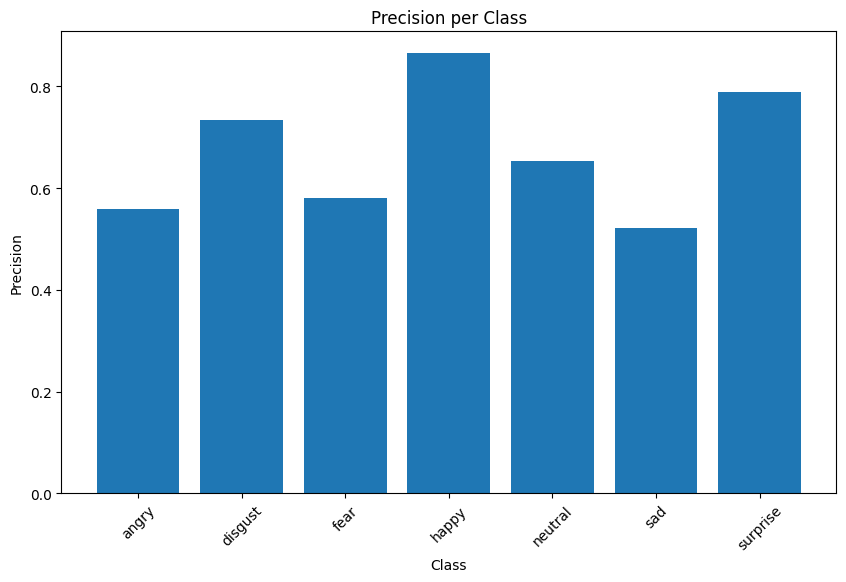

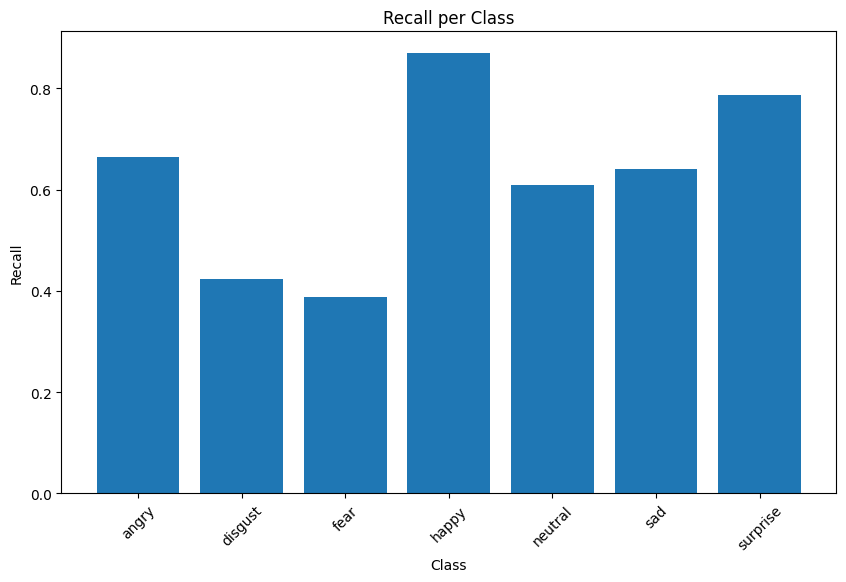

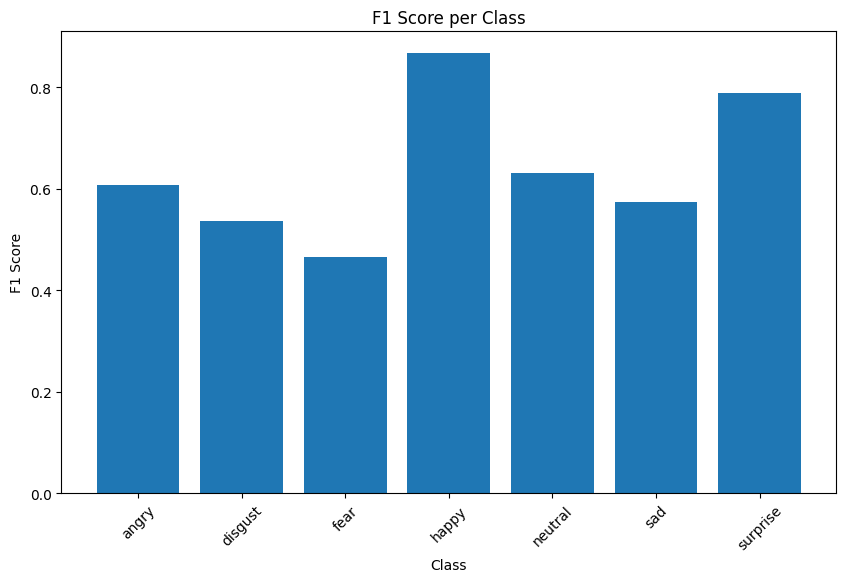

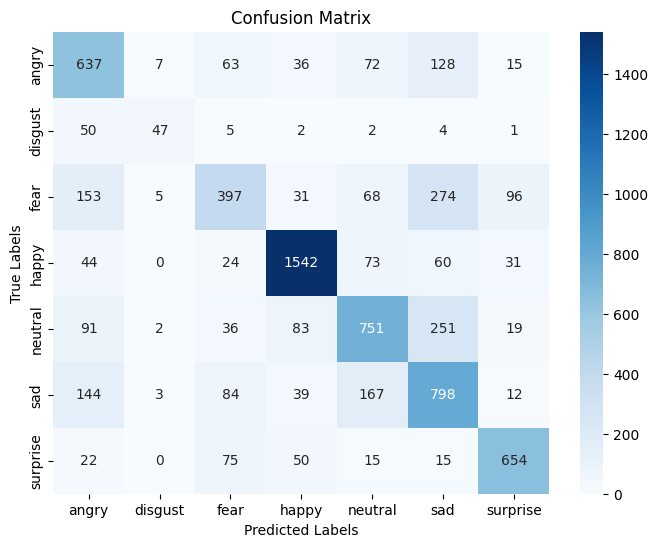

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = Vgg_face_dag()
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[train_dataset.class_to_idx[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Visualizza la matrice di confusione
plt.show()


In [27]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=ca1d742daeaddcba13ff407a26cafebcb103db0334bdcd2985987f2102b0d30f
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


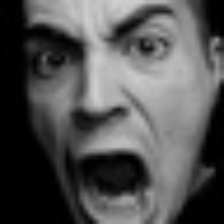

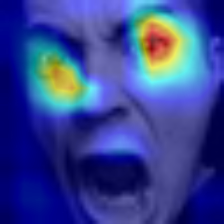

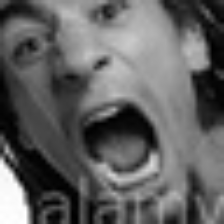

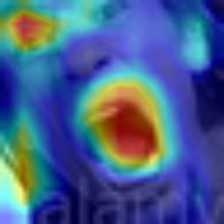

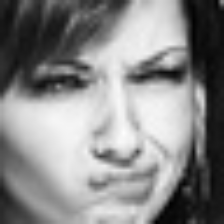

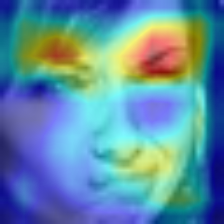

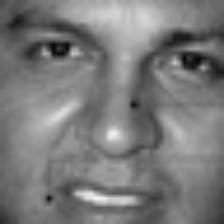

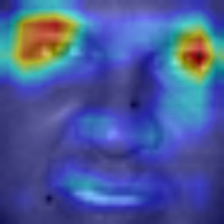

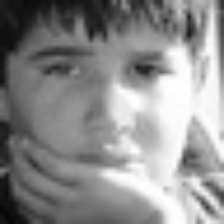

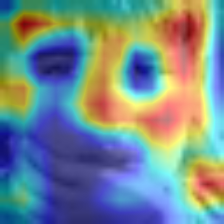

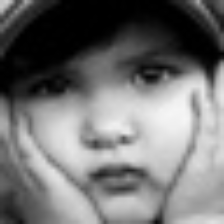

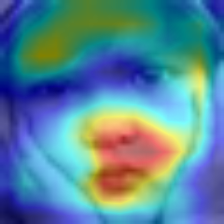

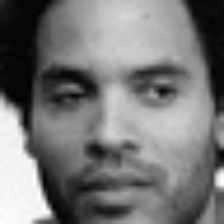

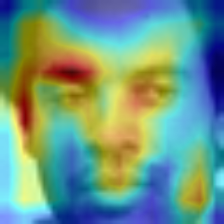

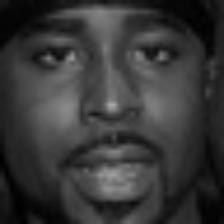

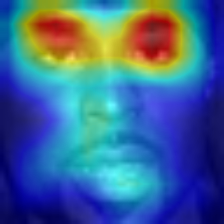

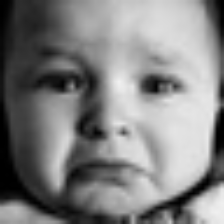

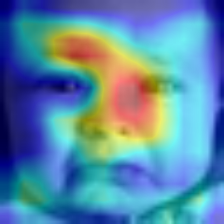

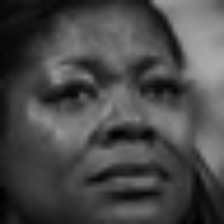

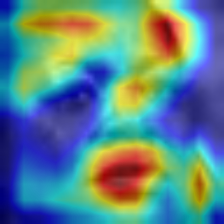

In [28]:
!pip install pillow
import numpy as np
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from google.colab.patches import cv2_imshow
from skimage.transform import resize

target_layers = [model.conv5_3]

# Percorsi delle immagini di input
input_image_paths = [
    '/content/test/angry/PrivateTest_20306434.jpg',
    '/content/test/angry/PrivateTest_20431702.jpg',

    '/content/train/disgust/Training_9948239.jpg',
    '/content/test/disgust/PrivateTest_57834460.jpg',

    '/content/test/fear/PrivateTest_14182117.jpg',
    '/content/test/fear/PrivateTest_1540303.jpg',

    '/content/test/neutral/PrivateTest_19817034.jpg',
    '/content/train/neutral/Training_10588719.jpg',

    '/content/train/sad/Training_10351430.jpg',
    '/content/train/sad/Training_10399611.jpg',

]

# Creazione di una lista per contenere le immagini elaborate
visualizations = []

for input_image_path in input_image_paths:
    input_image = Image.open(input_image_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    input_image = input_image.convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0)
    #print(input_tensor.shape)
    immagine = cv2.imread(input_image_path)
    #cv2_imshow(immagine)
    immagine=cv2.resize(immagine, (224,224))
    cv2_imshow(immagine)
    #print(input_image)
    input_image = immagine.astype(np.float32) / 255.0

    # Costruzione dell'oggetto CAM una volta sola e riutilizzo sulle immagini successive
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

    targets = [ClassifierOutputTarget(6)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=False)

    # Upscaling dell'immagine
    #upscaled_image = resize(visualization, (2 * input_image.shape[1], 2 * input_image.shape[0]), preserve_range=True)

    visualizations.append(visualization)


    #visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)
    #visualizations.append(visualization)
    cv2_imshow(visualization)


In [29]:
import numpy as np
import cv2

# Divisione delle immagini in due gruppi
group1_visualizations = visualizations[:5]
group2_visualizations = visualizations[5:]

# Creazione di un'immagine vuota per ospitare le immagini del primo gruppo
output1 = np.zeros((group1_visualizations[0].shape[0], 5 * group1_visualizations[0].shape[1], 3), dtype=np.uint8)

# Creazione di un'immagine vuota per ospitare le immagini del secondo gruppo
output2 = np.zeros((group2_visualizations[0].shape[0], 5 * group2_visualizations[0].shape[1], 3), dtype=np.uint8)

# Riempimento del primo file con le immagini del primo gruppo
for i, visualization in enumerate(group1_visualizations):
    start_col = i * visualization.shape[1]
    end_col = (i + 1) * visualization.shape[1]
    output1[:, start_col:end_col, :] = visualization

# Riempimento del secondo file con le immagini del secondo gruppo
for i, visualization in enumerate(group2_visualizations):
    start_col = i * visualization.shape[1]
    end_col = (i + 1) * visualization.shape[1]
    output2[:, start_col:end_col, :] = visualization

# Salvataggio delle immagini in due file separati
cv2.imwrite("/content/output1.jpg", output1)
cv2.imwrite("/content/output2.jpg", output2)


True